In [1]:
from generate_data import Data
from evaluate import *
from models import *

from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [4]:
%%time
data = Data(layer_size=16, interop_distances=[0,1,2])

C:\Users\Luna Santos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


CPU times: total: 1.72 s
Wall time: 1.8 s


In [5]:
%%time
train, val, test = data.get_splits(['omit_distances', 'random_subsample'], [[0, 2], [0.1, 0.9]])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 541 train | 1533 val | 6132 test
CPU times: total: 1min 36s
Wall time: 1min 36s


#### Peek at unshuffled train data

In [6]:
train_original[:20]

[['___,,_..,___.,,,', ',._.,.u_w.,__.__', '.,,_d,r,.,.,,,,,', 'A'],
 [',_._,___,_,_,_,,', '.,._.._,,,.w,u,,', ',,,,.,,c.r.,___,', 'V'],
 ['_,.,._,,._,,..,_', '.,.__...___..,,.', '._,_r,_,.,,,.___', 'R'],
 ['.._,_.,._,_,.__.', '__,,w,..,,_.,.,.', '_.___,,._,__,...', 'V'],
 ['_,_,_,.,...,,,_,', '.___,.,.....__.,', 'r.._,._,._,,..,,', 'R'],
 ['__...,_.._,,,.,.', ',._,,,,,,,,,_w._', '..._r,__,_,._,..', 'R'],
 ['_,_,,,_,,._,,.,.', '.__,,__._.,_.,_.', ',__._,.,.__,_.__', 'V'],
 ['.,,_..__,,_.._._', '_,_,_...w___._,,', ',,._,____,,__._.', 'V'],
 [',_.,..___,,_,.._', '..,____.u.w_,,,,', '_.,_._r_,._._,_.', 'R'],
 ['_,__.,,_...._,,_', ',..,_,_,_w,._._,', '..c_r_.,,,....,.', 'V'],
 ['_,._..,____,.,.,', ',_,_.._w,,_.__,.', ',.,,,._,..,___,.', 'V'],
 ['_.._.___,._._._,', '._...,_,__,._,_.', '__..,_,.r___.,.,', 'R'],
 ['..,,_,_...._.,__', ',_w.,..._.____._', 'r_,_,.,,,__...,_', 'R'],
 [',__,.__,_,..__,.', '._..,_..u.w,.,_.', ',,,,,_._,_.,,_,.', 'V'],
 ['_,._.._,.,..,_..', ',_,,_,,_..,,,._,', ',,.__

In [7]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 24 | F2-uw 13 | F2-w 22 | F2-noop 24 | 
F3 cr:    F2-wu 15 | F2-uw 18 | F2-w 19 | F2-noop 31 | 
F3 r:    F2-wu 22 | F2-uw 19 | F2-w 64 | F2-noop 75 | 
F3 noop:    F2-wu 22 | F2-uw 22 | F2-w 78 | F2-noop 73 | 

Positive samples count: 239
Total samples count: 541
Positive class ratio: 0.4417744916820702


#### Peek at test data

In [8]:
test_original[:15]

[['_...__._,.____.,', '__,_.._,.uw,__,_', '___.,__,__,__dr.', 'A'],
 ['..,._.,_,._,.,,.', ',,,.uw,.,,,.___,', ',__dr_,..,,__,,,', 'A'],
 [',,_,_,_,__.,,,,.', '___w._u_,.,._.,,', '._.,__,,,._,c_.r', 'V'],
 ['._.,...,_...,,,.', '_,,.,,wu,,_,,,,,', '_,.,_,___,,____.', 'V'],
 ['._,.,,,_,___.,__', '.,,,_,,.,.,..,,.', '_,_.___.._,r._,_', 'R'],
 [',._._,.._,_,_.,.', '..uw._.__,...,.,', '.,,._,,._,_.__,_', 'V'],
 ['_..,....__.__,.,', '.wu,..,,,._.,..,', '._.____,.,_.__,_', 'V'],
 ['_....,.,__,,__,_', ',.,__....,_,.,.,', '_,,.,_..__...,,,', 'V'],
 ['_,._._..,..__.,,', ',,,..,,,,_,.._w.', '.,..,.,.,.._,...', 'V'],
 [',,___,_,.._,,,,,', ',__,._._,,,,w,__', '.._.,_.,,._dr__.', 'D'],
 ['_._,_,_...._._._', ',_.__.wu_.,,_,_,', '_..,,r._,_.._.,.', 'R'],
 ['_,,_,,.,._.,..__', '_._.._,,_.__wu,,', '___.,_,_._,,.,,,', 'V'],
 [',,.,_.,,,,_.,,__', '_,.,,.,_,w,,u.._', ',_,._..._..____.', 'V'],
 ['__,__,_,..__.._,', '.__.,_,____,_,,.', ',.,.___.._...,dr', 'D'],
 ['_._,,...___,,_,_', ',,,._,_.,,.,..,.', 'r,,..

In [9]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 315 | F2-uw 309 | F2-w 326 | F2-noop 365 | 
F3 cr:    F2-wu 333 | F2-uw 306 | F2-w 341 | F2-noop 369 | 
F3 r:    F2-wu 347 | F2-uw 335 | F2-w 483 | F2-noop 524 | 
F3 noop:    F2-wu 351 | F2-uw 369 | F2-w 511 | F2-noop 548 | 

Positive samples count: 2689
Total samples count: 6132
Positive class ratio: 0.43851924331376385


#### Peek at val data

In [10]:
val_original[:15]

[[',_._,___.,.,,,.,', ',.,_.__.__,,,...', '.,,..___.__,,.cr', 'V'],
 ['_______,.,_.,._,', '.,_._,,__,.,.wu,', ',_.__._,,,.,__,,', 'V'],
 ['__..,.._.,__,.__', '.___,_.w_._,_...', ',_,_,.,_..,,____', 'V'],
 ['.._.,.,,._.._..,', ',..,_w..,.,,.,_.', ',_..,,._r__,,_,_', 'R'],
 ['_____.___._,..,,', '.,___,._,.,w_,._', ',_.,r..,_,._,_,,', 'R'],
 [',.,,_.,,,__.,__.', ',.,,,,.,u,,w.._,', 'd,_r_,_....,,._,', 'A'],
 ['._.,,_,,.,._,_,.', '.__.__._uw..,,,,', '_.__,,_.dr_,,.._', 'A'],
 ['.,__,.,.....,.,.', '..__uw_.___,___,', '__,..._,.r._,.,_', 'R'],
 ['_._____.._.._,,,', '.,__wu._,,,.____', '_,___cr,_.,_.__.', 'V'],
 ['...._..,_.,.._,,', '._w..u_.__..,.,.', '__._,_.,._,,d.,r', 'V'],
 ['._,.._,,.,,__.,.', '_..._,...,_,,_,,', '_,_._,r..__,._,,', 'R'],
 [',_,__.,,__,,..__', ',,__,,,._._,wu_.', '.cr..,,,,._,.._,', 'V'],
 [',,.,.,._,__.,,,_', '_...,..._.w__._.', ',._..,.d..r.,._.', 'D'],
 ['._._,_,_,,_,_,_,', '.__..,.,__.u__w_', ',_,,,_.,,..,r,.,', 'R'],
 ['_..__.,..,,...,,', ',,,_w.,u...,.._,', ',.,,.

In [11]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 79 | F2-uw 85 | F2-w 96 | F2-noop 85 | 
F3 cr:    F2-wu 61 | F2-uw 88 | F2-w 81 | F2-noop 81 | 
F3 r:    F2-wu 75 | F2-uw 87 | F2-w 130 | F2-noop 123 | 
F3 noop:    F2-wu 99 | F2-uw 81 | F2-w 133 | F2-noop 149 | 

Positive samples count: 681
Total samples count: 1533
Positive class ratio: 0.44422700587084146


#### Send label arrays to device

In [12]:
#y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
#y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
#y_test = torch.from_numpy(y_test.astype(float)).float().to(device)
#---------------------------------------------------------------------------------------CAMBIO
# Crear un codificador de etiquetas
label_encoder = LabelEncoder()

#input_tensor = input_tensor.requires_grad_()  # Esto habilita el cálculo de gradientes

#cambio de torch.float a torch.long

# Ajustar el codificador a las etiquetas y transformarlas a num enteros
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

y_trainP = y_train

#Un tensor es una estructura de datos similar a matrices o arrays, pero con soporte para operaciones avanzadas en GPU.
# Convertir las etiquetas a tensores de PyTorch
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

#se mueven los datos a la CPU o GPU para que puedan ser procesados por PyTorch durante el entrenamiento o la inferencia

#### Get data in normal format (same as CNN format)

In [13]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [14]:
x_train_normal[0].shape

torch.Size([541, 128])

#### Get data in convolutional format, send to device

In [15]:
x_train_cnn = data.to_conv_format(x_train, padding_left_size=2, padding_right_size=2)
x_val_cnn = data.to_conv_format(x_val, padding_left_size=2, padding_right_size=2)
x_test_cnn = data.to_conv_format(x_test, padding_left_size=2, padding_right_size=2)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [16]:
x_train_cnn[0].shape

torch.Size([541, 160])

#### Get data in LSTM format, send to device

In [17]:
x_train_lstm = data.to_lstm_format(x_train)
x_val_lstm = data.to_lstm_format(x_val)
x_test_lstm = data.to_lstm_format(x_test)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [18]:
x_train_lstm[0].shape

torch.Size([541, 16, 8])

### Define training parameters

In [19]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100
#experiment_name = "interop_2"

### Define training procedure for each model

In [20]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = [] #lista con la precisión de cada modelo en el cjto de prueba
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []#lista con las predicciones incorrectas del modelo en el cjto de prueba
    best_accuracy = 0
    
    #listas de listas de cada modelo durante el entrenamiento y prueba
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1-pos_train_ratio)/pos_train_ratio]).to(device))
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./temp/{model_name}_model_TEMP')    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break

        model.load_state_dict(torch.load(f'./temp/{model_name}_model_TEMP'))

        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original)) #Se evalúa el modelo en el conjunto de prueba 
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1_scores.append(get_f1(precisions[-1], recalls[-1]))        
        
        wrong_preds.append(get_wrong_predictions(model, x_test, y_test, test_original))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./bestmodels/best_{model_name}_model_')    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | METRICS:")
        print("Accuracy ", accuracies[-1]['Overall'])
        print("Precision ", precisions[-1]['Overall'])
        print("Recalls ", recalls[-1]['Overall'])
        print("F1_scores ", f1_scores[-1]['Overall'])
        print("---------------------------------------------------------------------")
        
    return accuracies, precisions, recalls, f1_scores,  wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [21]:
%%time
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, cnn_wrong_preds, cnn_epoch_stats = train_models(CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.005, data, 32, 64, 4, -1, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.7653294194390085
Precision  0.3844375940886473
Recalls  0.4681237293058379
F1_scores  0.4221734092126319
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.5870841487279843
Precision  0.4382489330665407
Recalls  0.4761719170510129
F1_scores  0.4564240515229472
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.7852250489236791
Precision  0.3897084803725823
Recalls  0.47668066096130035
F1_scores  0.42882923421736924
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.7322243966079582
Precision  0.3678719961113691
Recalls  0.4502166467448304
F1_scores  0.4049001241292145
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.7914220482713633
Precision  0.510296675436851
Recalls  0.6167671090646443

In [22]:
%%time
lstm_accuracies, lstm_precisions, lstm_recall, lstm_f1_scores, lstm_wrong_preds, lstm_epoch_stats = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.9983692106979778
Precision  0.9937379999537348
Recalls  0.9963280874754556
F1_scores  0.9950313582043971
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.9993476842791911
Precision  0.9997098926602843
Recalls  0.9967637540453075
F1_scores  0.9982346495868779
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.9991846053489889
Precision  0.9960191082802548
Recalls  0.9996369445251234
F1_scores  0.9978247470953464
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  1.0
Precision  1.0
Recalls  1.0
F1_scores  1.0
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  1.0
Precision  1.0
Recalls  1.0
F1_scores  1.0
---------------------------------------------------------------------
6 / 20 models traine

In [23]:
%%time
deepset_accuracies, deepset_precisions, deepset_recall, deepset_f1_scores, deepset_wrong_preds, deepset_epoch_stats = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.7707110241356817
Precision  0.5788874970309839
Recalls  0.6163928838503254
F1_scores  0.5970517703247689
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.7852250489236791
Precision  0.6347174069332153
Recalls  0.6314641672180273
F1_scores  0.6330866077506097
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.7278212654924984
Precision  0.49403091902441254
Recalls  0.5379337660982482
F1_scores  0.5150484637140326
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.7819634703196348
Precision  0.5822600866866604
Recalls  0.6297639777882426
F1_scores  0.6050811020125765
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.7736464448793215
Precision  0.5708159458449766
Recalls  0.613026731296175


In [24]:
%%time
deepsetv2_accuracies, deepsetv2_precisions, deepsetv2_recall, deepsetv2_f1_scores, deepsetv2_wrong_preds, deepsetv2_epoch_stats = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.7899543378995434
Precision  0.4593323269206783
Recalls  0.5328764633070004
F1_scores  0.4933787893491652
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.8091976516634051
Precision  0.6082635804318868
Recalls  0.6214485482731449
F1_scores  0.6147853797699551
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.8486627527723418
Precision  0.6394316606033348
Recalls  0.6526849276197857
F1_scores  0.6459903245923194
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.7977821265492498
Precision  0.5347610211752657
Recalls  0.6431118535855667
F1_scores  0.583952918727612
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.7850619699934769
Precision  0.4396109136921804
Recalls  0.4910002269385235
F

In [25]:
%%time
feedforward_accuracies, feedforward_precisions, feedforward_recall, feedforward_f1_scores, feedforward_wrong_preds, feedforward_epoch_stats = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.74706457925636
Precision  0.5830154348444253
Recalls  0.5467445812688517
F1_scores  0.5642977716522972
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.7292889758643183
Precision  0.6210012469900241
Recalls  0.5938343879385577
F1_scores  0.6071140569350875
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.7697325505544683
Precision  0.6098671326680236
Recalls  0.6182690072727653
F1_scores  0.6140393306903676
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.7557077625570776
Precision  0.5301117395037327
Recalls  0.5820112761992426
F1_scores  0.5548505078671442
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.7493476842791911
Precision  0.5575816075816076
Recalls  0.5786788910631208
F1

# Evaluation

In [26]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
all_precisions = [cnn_precisions, lstm_precisions, deepset_precisions, deepsetv2_precisions, feedforward_precisions]
all_recalls = [cnn_recall, lstm_recall, deepset_recall, deepsetv2_recall, feedforward_recall]
all_f1_scores = [cnn_f1_scores, lstm_f1_scores, deepset_f1_scores, deepsetv2_f1_scores, feedforward_f1_scores]

model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [27]:
get_summary_df(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

                   Modelo  Accuracy  Precision    Recall  F1-score  \
0                     CNN  0.976517   0.927261  0.960086  0.943388   
1                    LSTM  1.000000   1.000000  1.000000  1.000000   
2  DeepSet(like in paper)  0.794521   0.650824  0.661635  0.656185   
3   DeepSet(sum at start)  0.881115   0.728007  0.707806  0.717764   
4             Feedforward  0.817352   0.674184  0.680723  0.677438   

   Precision clase A  Recall clase A  Precision clase D  Recall clase D  \
0           0.721180        0.870550           1.000000        1.000000   
1           1.000000        1.000000           1.000000        1.000000   
2           0.406250        0.084142           0.608392        0.745714   
3           0.402439        0.106796           0.682670        0.811978   
4           0.417323        0.171521           0.600605        0.725777   

   Precision clase R  Recall clase R  Precision clase V  Recall clase V  
0           0.999408        1.000000           0.98845

## Accuracies per CNN model

In [28]:
get_stats_per_model_multiclass(cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, ['CNN #' + str(i) for i in range(len(cnn_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,CNN #0,0.765329,0.422173,0.384438,0.468124,0.000000,0.000000,0.542389,0.995361,0.000000,0.000000,1.000000,0.872495
1,CNN #1,0.587084,0.456424,0.438249,0.476172,0.095331,0.129688,0.527977,1.000000,0.158576,0.129688,1.000000,0.616424
2,CNN #2,0.785225,0.428829,0.389708,0.476681,0.000000,0.000000,0.564868,0.993966,0.000000,0.000000,0.997632,0.909091
3,CNN #3,0.732224,0.404900,0.367872,0.450217,0.000000,0.000000,0.528223,0.943265,0.000000,0.000000,0.975133,0.825733
4,CNN #4,0.791422,0.558503,0.510297,0.616767,0.000000,0.462366,0.578821,1.000000,0.000000,0.551282,1.000000,0.915786
5,CNN #5,0.619048,0.377424,0.354907,0.402992,0.000000,0.000000,0.419627,1.000000,0.000000,0.000000,1.000000,0.611966
6,CNN #6,0.791259,0.429297,0.388946,0.478990,0.000000,0.000000,0.589888,0.965895,0.000000,0.000000,0.994671,0.921290
7,CNN #7,0.950424,0.857301,0.867252,0.847575,0.523810,1.000000,0.995873,0.949327,0.427184,1.000000,1.000000,0.963114
8,CNN #8,0.728637,0.816856,0.762788,0.879175,0.495192,1.000000,0.555958,1.000000,1.000000,1.000000,1.000000,0.516701
9,CNN #9,0.793379,0.428781,0.387926,0.479256,0.000000,0.000000,0.608965,0.942739,0.000000,0.000000,0.989343,0.927679


## Accuracies per LSTM model

In [29]:
get_stats_per_model_multiclass(lstm_accuracies, lstm_precisions,lstm_recall, lstm_f1_scores, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,LSTM #0,0.998369,0.995031,0.993738,0.996328,0.980707,0.994245,1.000000,1.000000,0.987055,1.000000,1.000000,0.998257
1,LSTM #1,0.999348,0.998235,0.999710,0.996764,1.000000,1.000000,1.000000,0.998840,0.987055,1.000000,1.000000,1.000000
2,LSTM #2,0.999185,0.997825,0.996019,0.999637,0.984076,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998548
3,LSTM #3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,LSTM #4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,LSTM #5,0.998043,0.994692,0.999132,0.990291,1.000000,1.000000,1.000000,0.996527,0.961165,1.000000,1.000000,1.000000
6,LSTM #6,0.999837,0.999559,0.999927,0.999191,1.000000,1.000000,1.000000,0.999710,0.996764,1.000000,1.000000,1.000000
7,LSTM #7,0.897913,0.650593,0.630892,0.671564,0.000000,0.524752,0.998817,1.000000,0.000000,0.686255,1.000000,1.000000
8,LSTM #8,0.996738,0.990706,0.997691,0.983819,1.000000,0.995677,1.000000,0.995087,0.935275,1.000000,1.000000,1.000000
9,LSTM #9,0.999185,0.998455,0.998898,0.998013,0.996753,1.000000,1.000000,0.998839,0.993528,1.000000,0.998816,0.999710


## Accuracies per DeepSets V1 model

In [30]:
get_stats_per_model_multiclass(deepset_accuracies, deepset_precisions,deepset_recall, deepset_f1_scores, ['DEEPSETS #' + str(i) for i in range(len(deepset_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,DEEPSETS #0,0.770711,0.597052,0.578887,0.616393,0.225000,0.544601,0.713333,0.832616,0.029126,0.684366,0.826010,0.926070
1,DEEPSETS #1,0.785225,0.633087,0.634717,0.631464,0.394737,0.554795,0.730692,0.858646,0.048544,0.698276,0.867778,0.911259
2,DEEPSETS #2,0.727821,0.515048,0.494031,0.537934,0.163934,0.366834,0.658981,0.786374,0.032362,0.445122,0.745300,0.928950
3,DEEPSETS #3,0.781963,0.605081,0.582260,0.629764,0.212121,0.554762,0.693198,0.868960,0.022654,0.691395,0.892198,0.912810
4,DEEPSETS #4,0.773646,0.591169,0.570816,0.613027,0.200000,0.505319,0.726571,0.851374,0.038835,0.653670,0.839881,0.919721
5,DEEPSETS #5,0.778376,0.615925,0.605626,0.626579,0.309524,0.546256,0.730084,0.836642,0.042071,0.704545,0.826706,0.932994
6,DEEPSETS #6,0.749022,0.530637,0.502082,0.562637,0.086957,0.429078,0.667760,0.824533,0.006472,0.472656,0.859469,0.911950
7,DEEPSETS #7,0.776745,0.625556,0.637374,0.614169,0.454545,0.512862,0.727861,0.854227,0.032362,0.648374,0.868765,0.907176
8,DEEPSETS #8,0.794521,0.656185,0.650824,0.661635,0.406250,0.608392,0.717504,0.871152,0.084142,0.745714,0.905806,0.910879
9,DEEPSETS #9,0.780659,0.577735,0.541319,0.619405,0.083333,0.514113,0.687644,0.880186,0.003236,0.669291,0.894800,0.910291


## Accuracies per DeepSets V2 model

In [31]:
get_stats_per_model_multiclass(deepsetv2_accuracies, deepsetv2_precisions,deepsetv2_recall, deepsetv2_f1_scores, ['DEESETS V2 #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,DEESETS V2 #0,0.789954,0.493379,0.459332,0.532876,0.235294,0.000000,0.676262,0.925773,0.258900,0.000000,0.959739,0.912867
1,DEESETS V2 #1,0.809198,0.614785,0.608264,0.621449,0.210526,0.536511,0.770537,0.915480,0.012945,0.694226,0.843020,0.935604
2,DEESETS V2 #2,0.848663,0.645990,0.639432,0.652685,0.263158,0.491187,0.876305,0.927077,0.016181,0.626687,0.999405,0.968467
3,DEESETS V2 #3,0.797782,0.583953,0.534761,0.643112,0.000000,0.555556,0.666126,0.917363,0.000000,0.675676,0.989157,0.907615
4,DEESETS V2 #4,0.785062,0.463887,0.439611,0.491000,0.201835,0.000000,0.618622,0.937987,0.071197,0.000000,0.983422,0.909381
5,DEESETS V2 #5,0.804631,0.616157,0.586133,0.649423,0.172414,0.586826,0.683968,0.901325,0.016181,0.666667,0.977858,0.936987
6,DEESETS V2 #6,0.561481,0.179791,0.140370,0.250000,0.000000,0.000000,0.000000,0.561481,0.000000,0.000000,0.000000,1.000000
7,DEESETS V2 #7,0.780496,0.483495,0.461692,0.507459,0.294798,0.000000,0.616876,0.935096,0.165049,0.000000,0.960924,0.903863
8,DEESETS V2 #8,0.275440,0.107979,0.068860,0.250000,0.000000,0.000000,0.275440,0.000000,0.000000,0.000000,1.000000,0.000000
9,DEESETS V2 #9,0.786367,0.505147,0.470048,0.545910,0.274788,0.000000,0.622029,0.983376,0.313916,0.000000,0.976317,0.893407


## Accuracies per FeedForward model

In [32]:
get_stats_per_model_multiclass(feedforward_accuracies, feedforward_precisions,feedforward_recall, feedforward_f1_scores, ['FEED FORWARD #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,FEED FORWARD #0,0.747065,0.564298,0.583015,0.546745,0.500000,0.369231,0.641947,0.820884,0.003236,0.417391,0.849488,0.916863
1,FEED FORWARD #1,0.729289,0.607114,0.621001,0.593834,0.500000,0.554622,0.546977,0.882406,0.003236,0.704626,0.796076,0.871399
2,FEED FORWARD #2,0.769733,0.614039,0.609867,0.618269,0.363636,0.532091,0.688825,0.854916,0.051780,0.660668,0.852713,0.907915
3,FEED FORWARD #3,0.755708,0.554851,0.530112,0.582011,0.105634,0.466546,0.678813,0.869454,0.048544,0.536383,0.824273,0.918846
4,FEED FORWARD #4,0.749348,0.567934,0.557582,0.578679,0.300000,0.444444,0.642857,0.843025,0.009709,0.581081,0.800481,0.923445
5,FEED FORWARD #5,0.794357,0.629333,0.610729,0.649105,0.309091,0.511673,0.735481,0.886672,0.110032,0.665823,0.896490,0.924074
6,FEED FORWARD #6,0.764840,0.653598,0.675207,0.633329,0.538462,0.616314,0.770647,0.775405,0.022654,0.750000,0.867891,0.892773
7,FEED FORWARD #7,0.734018,0.562122,0.538815,0.587536,0.176471,0.504098,0.678571,0.796119,0.019417,0.689076,0.743331,0.898320
8,FEED FORWARD #8,0.793216,0.640379,0.642978,0.637799,0.407407,0.567568,0.737212,0.859727,0.035599,0.715328,0.872922,0.927349
9,FEED FORWARD #9,0.756034,0.625454,0.624504,0.626407,0.405172,0.576453,0.669908,0.846482,0.152104,0.715370,0.738095,0.900061


# Training evolution

### CNN

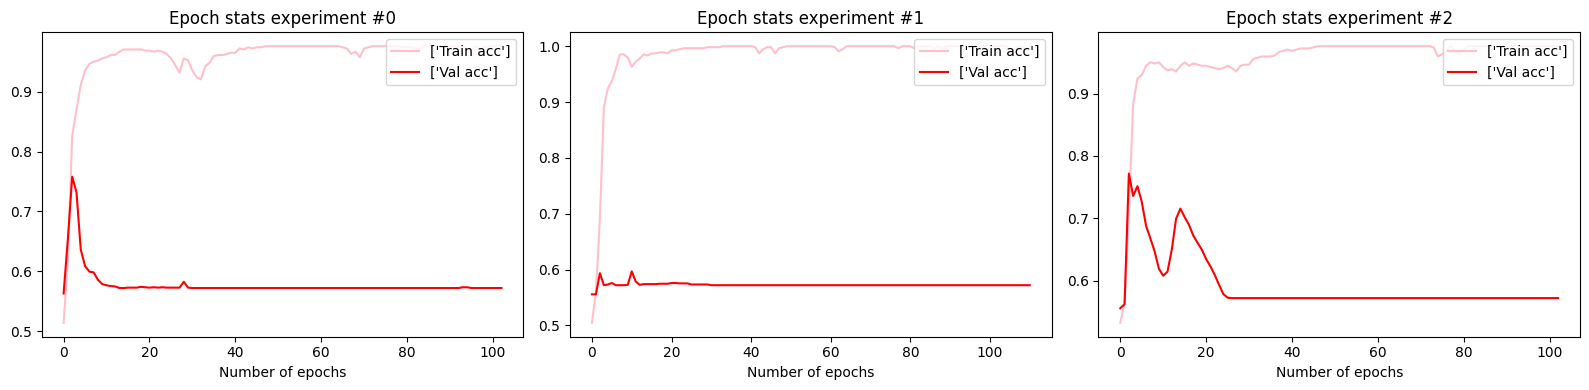

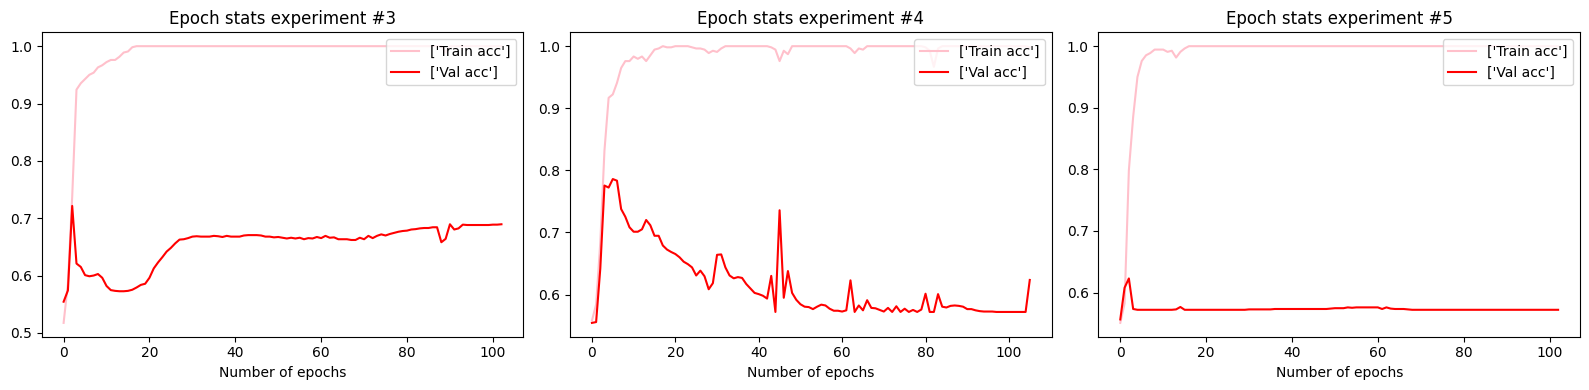

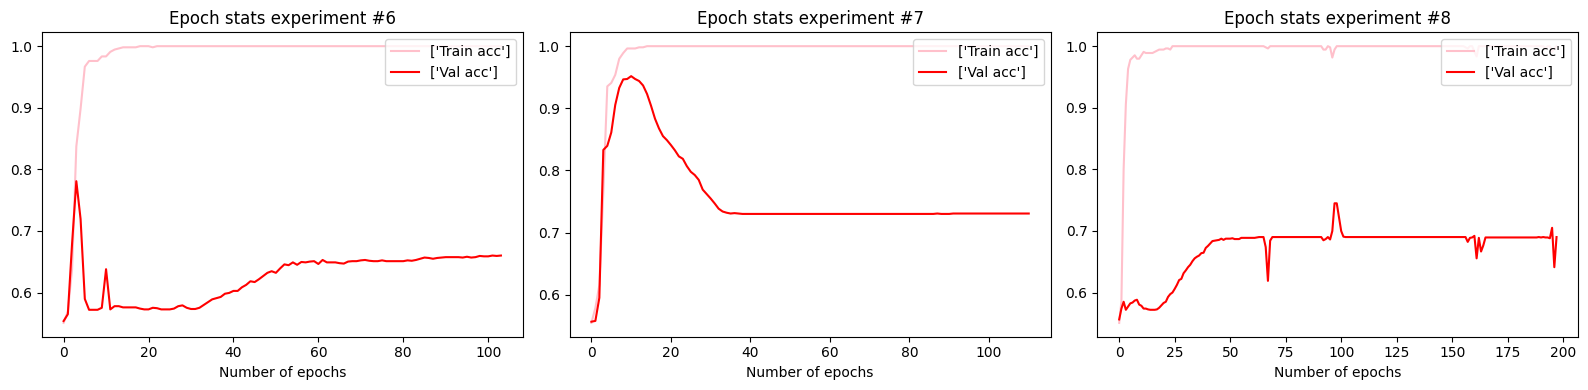

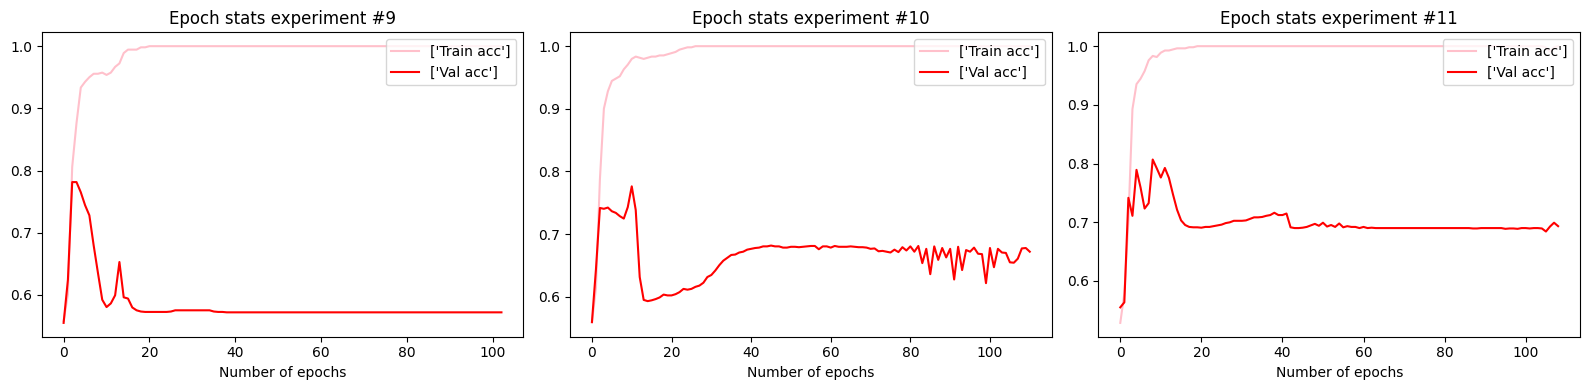

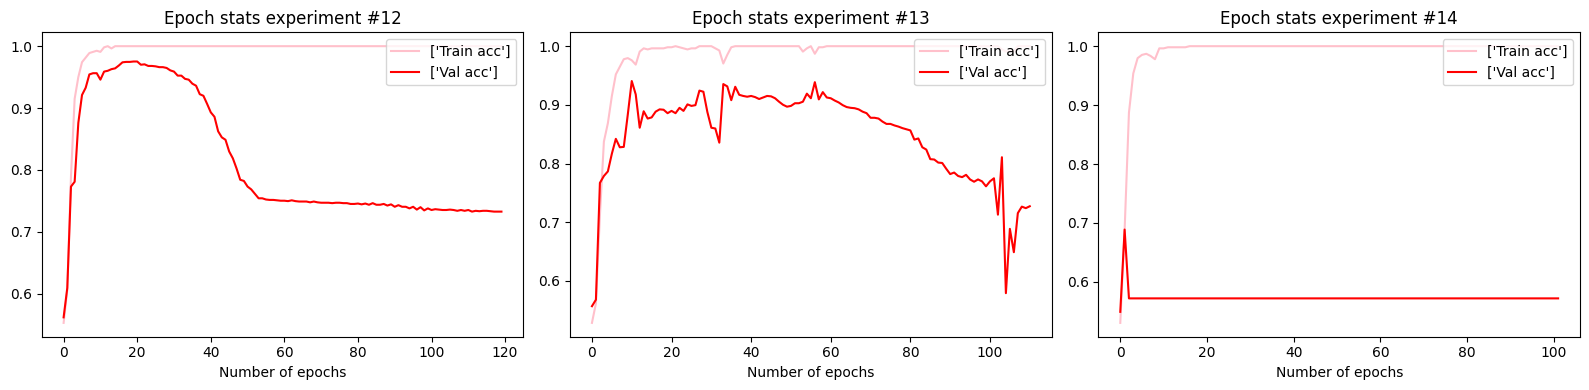

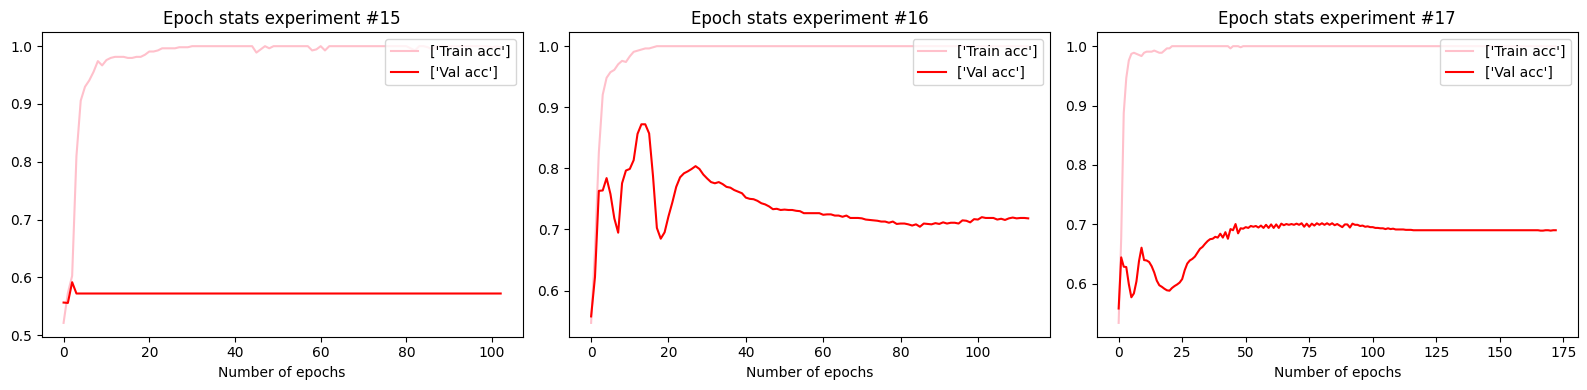

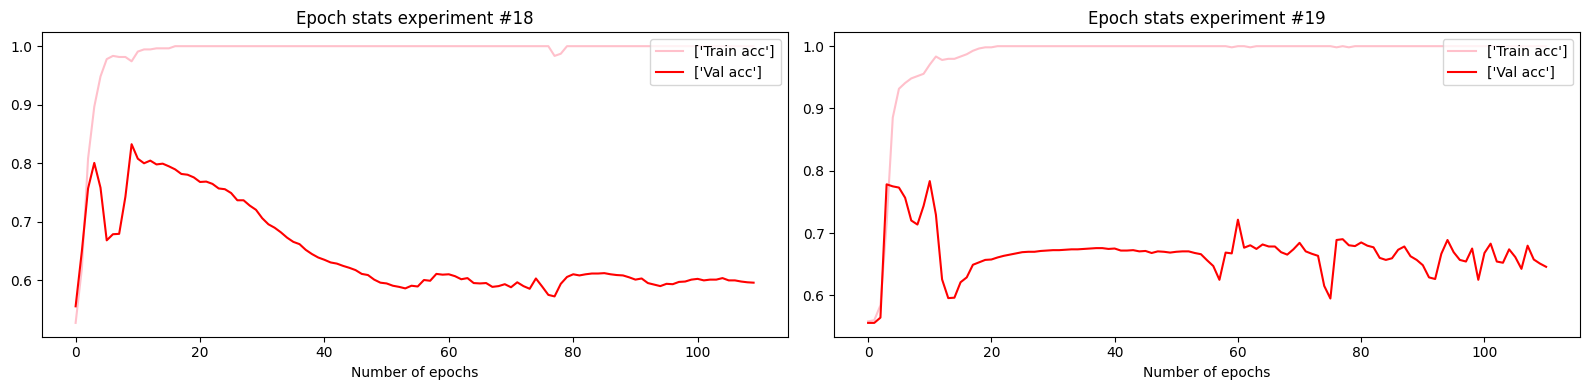

In [33]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

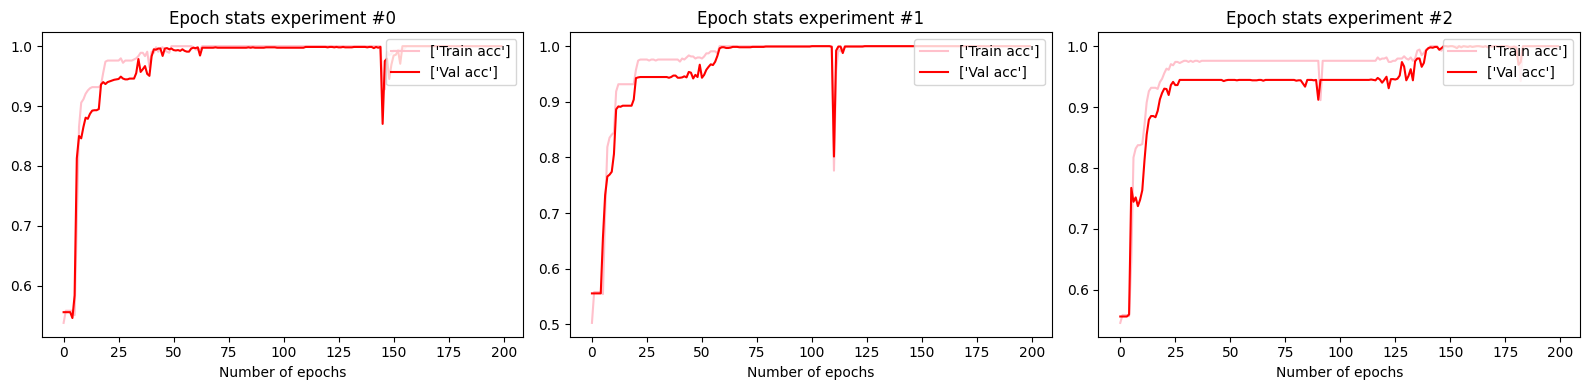

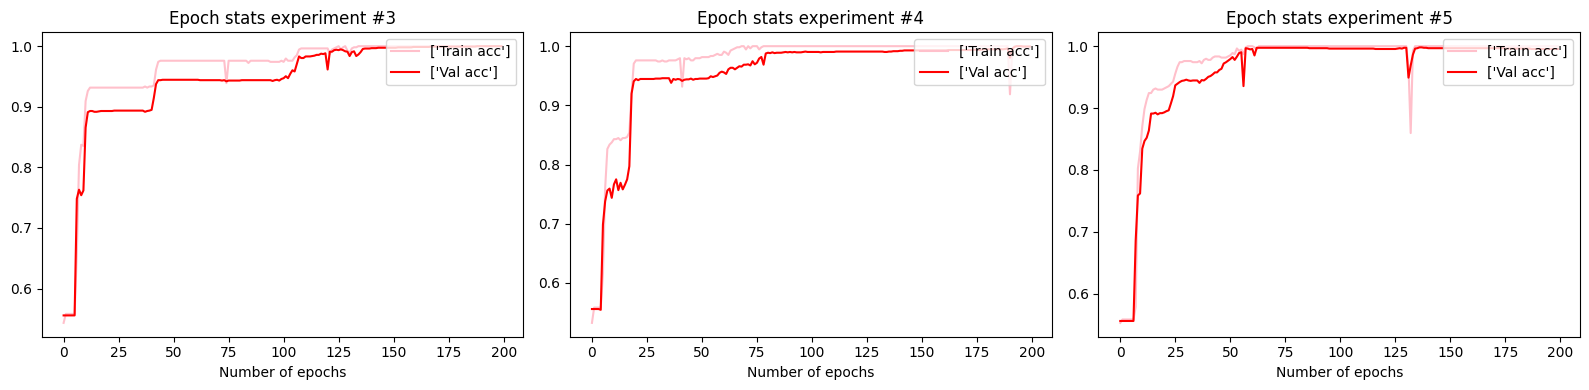

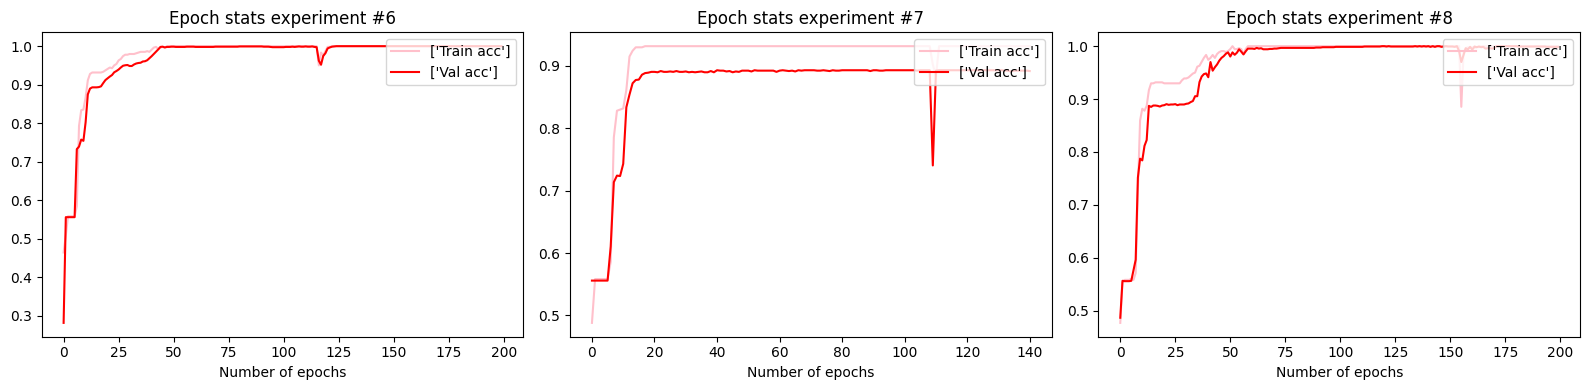

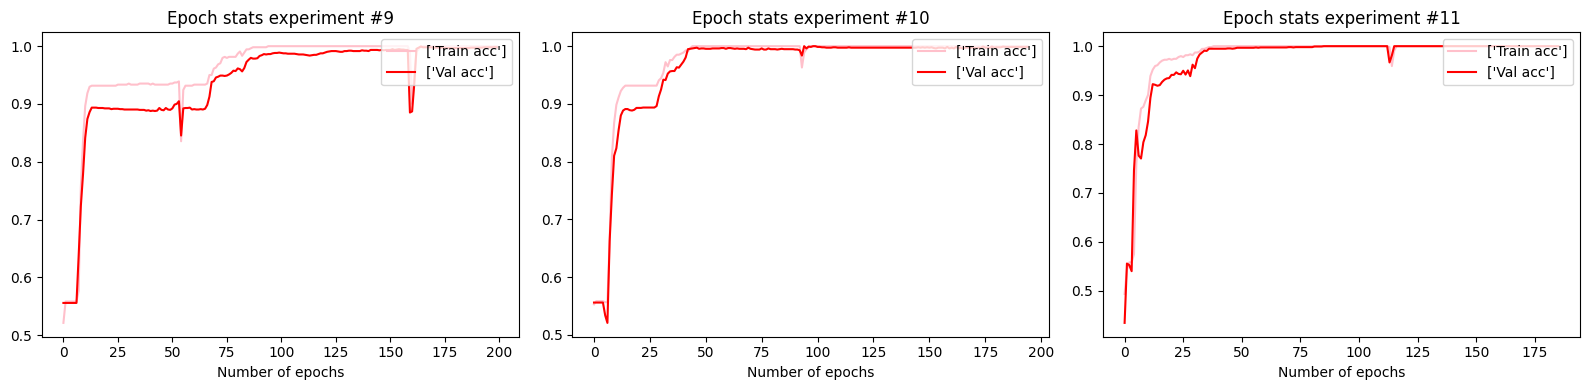

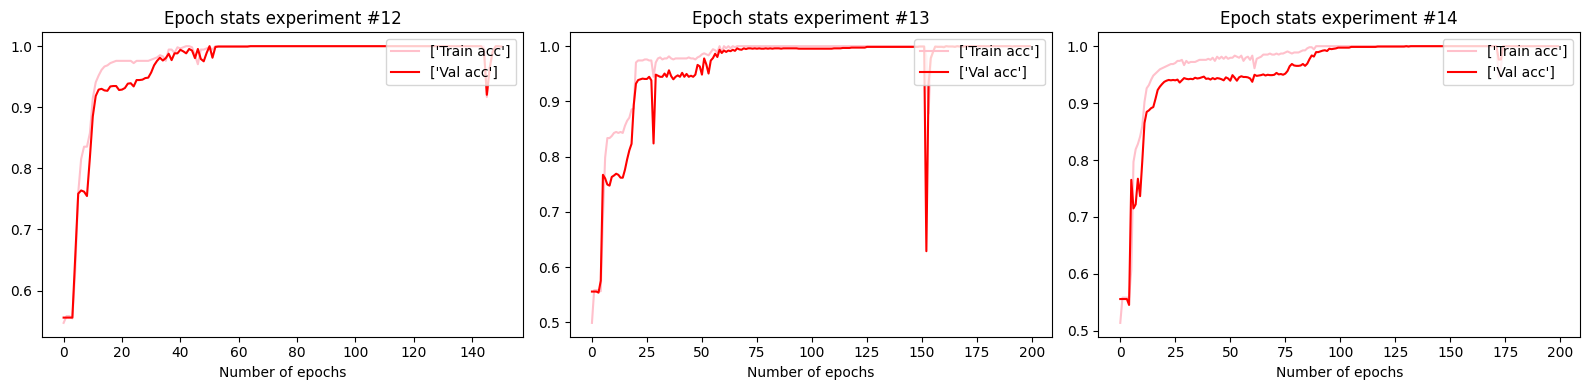

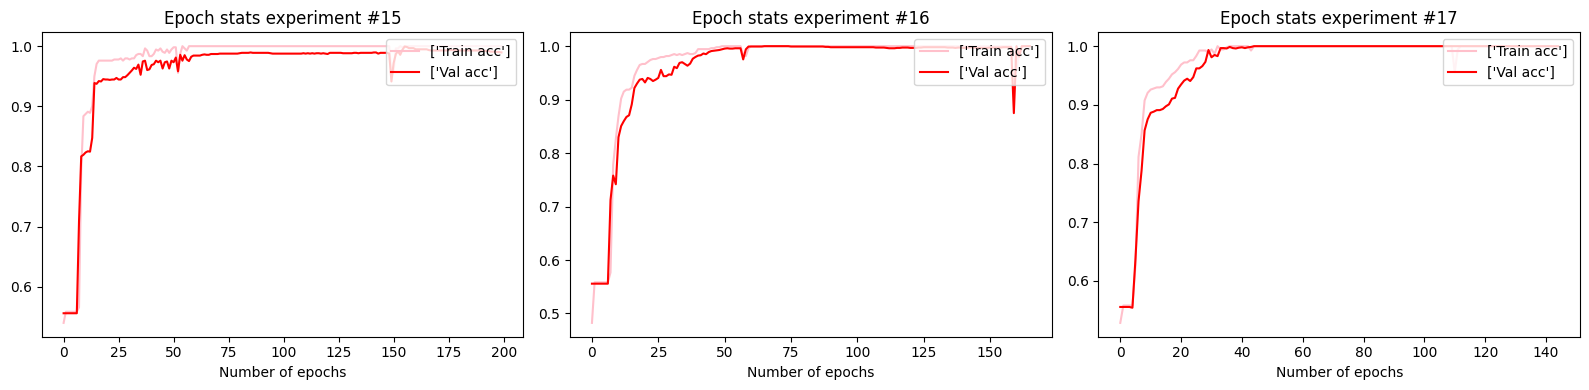

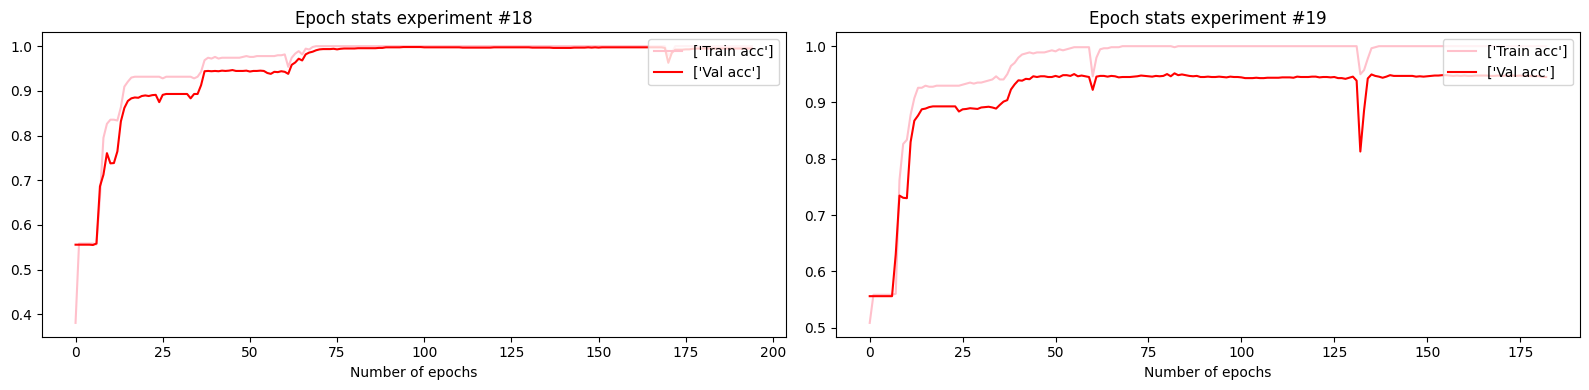

In [34]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

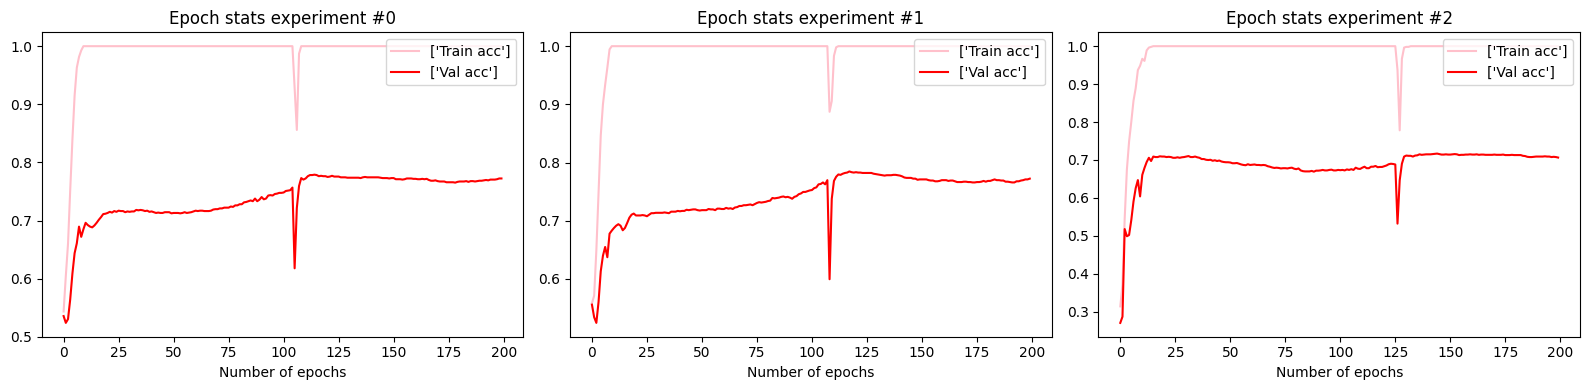

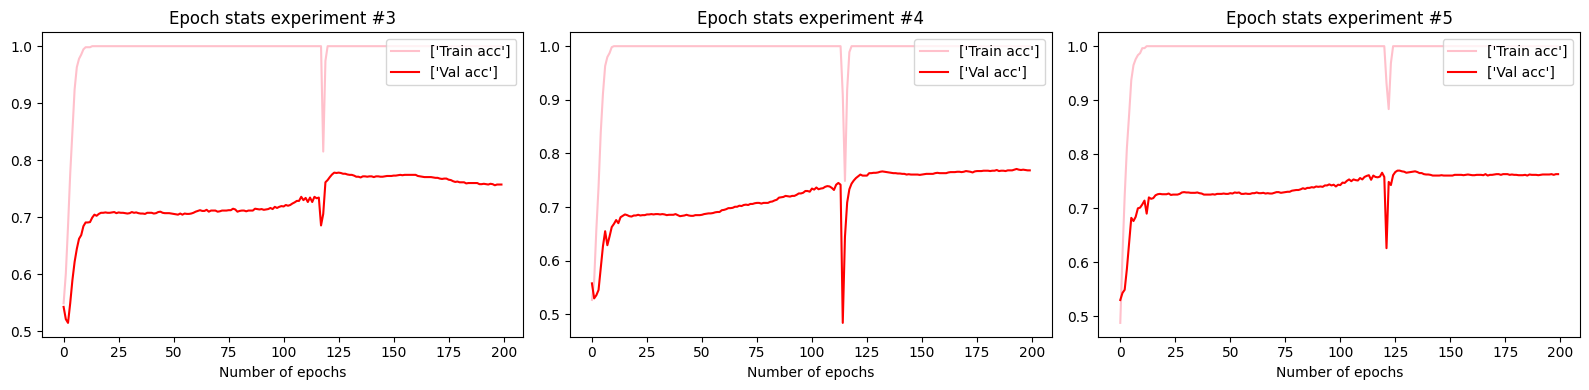

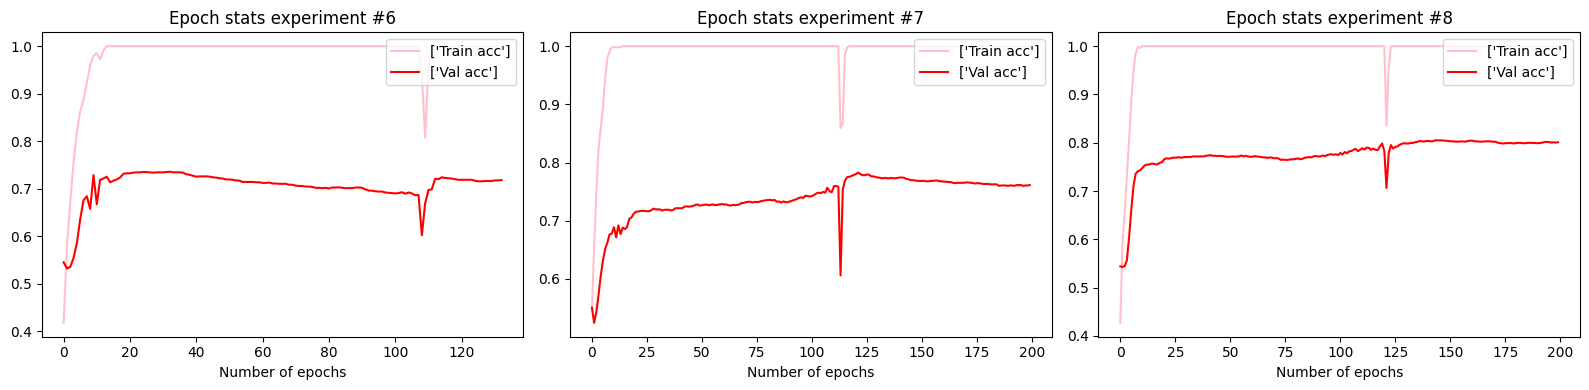

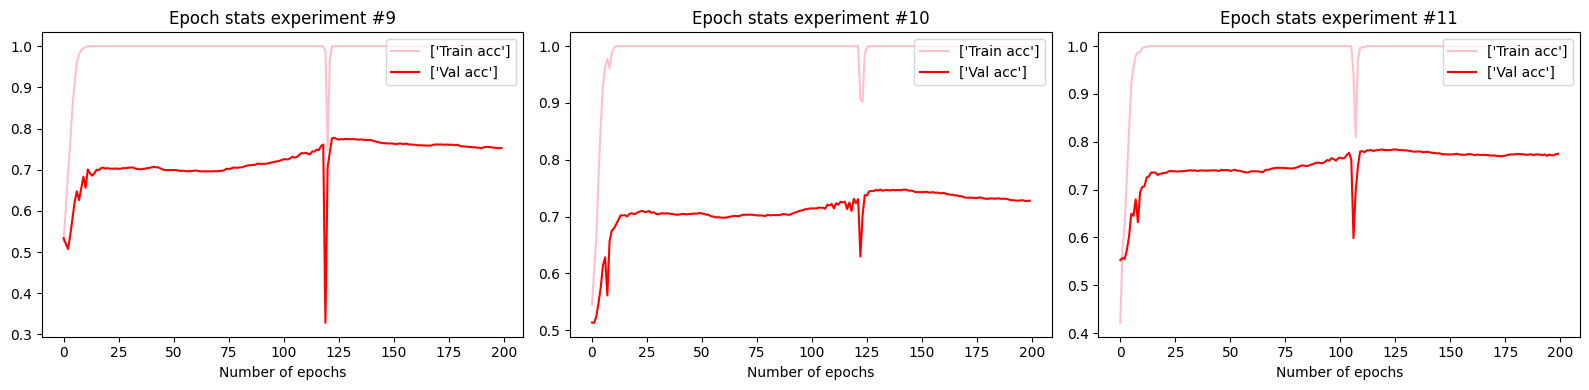

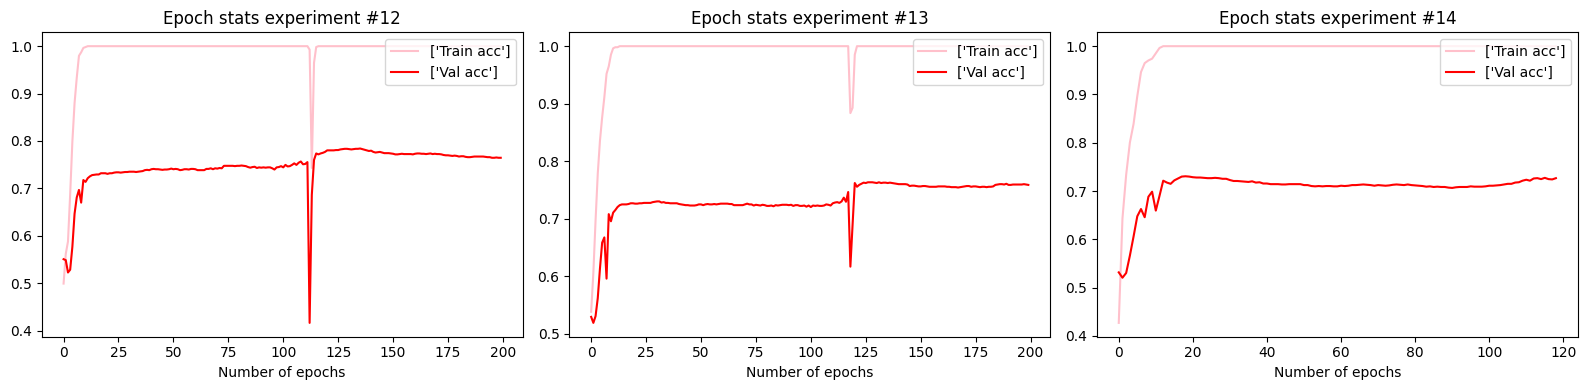

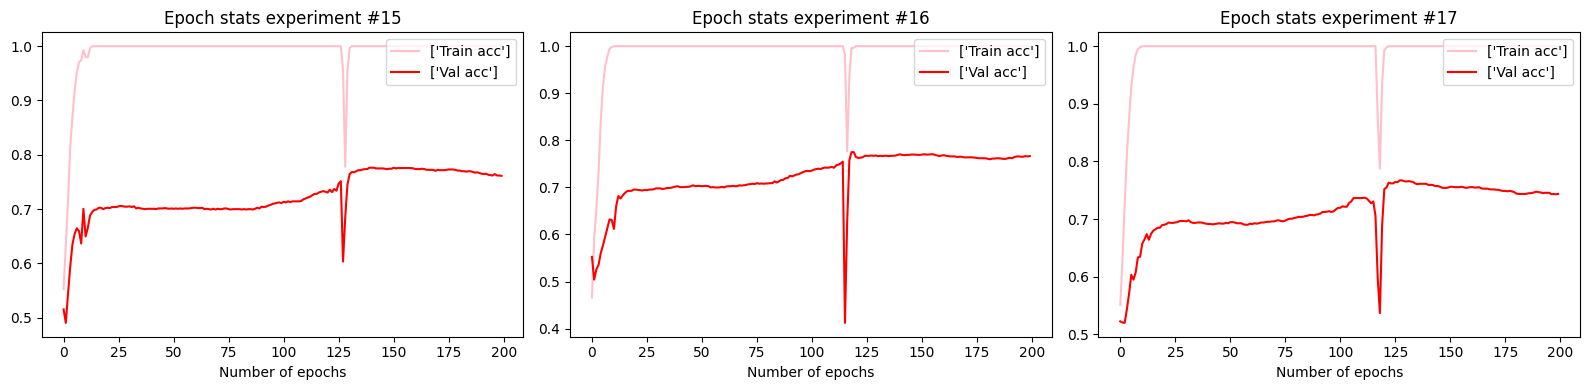

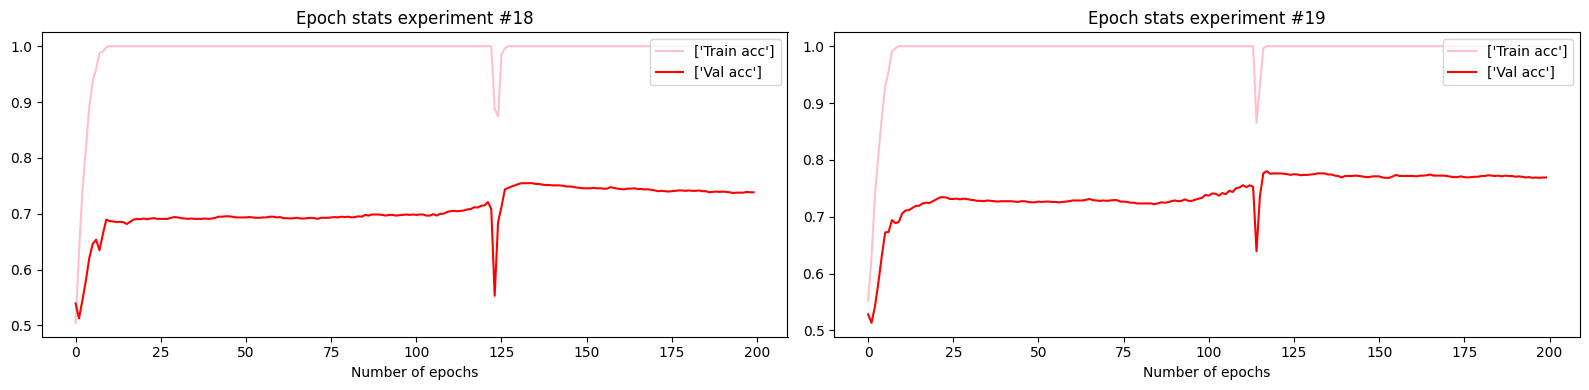

In [35]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

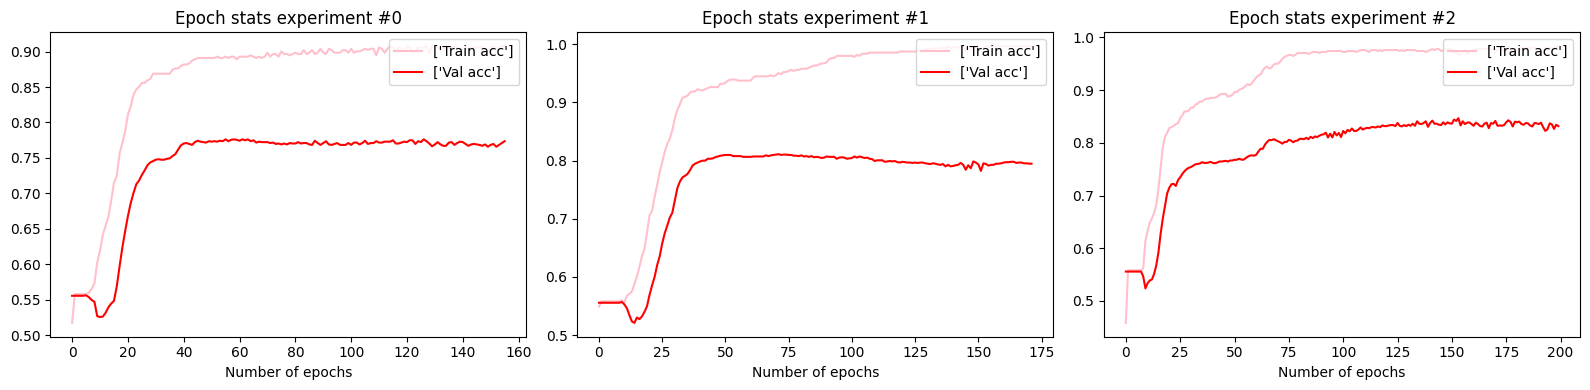

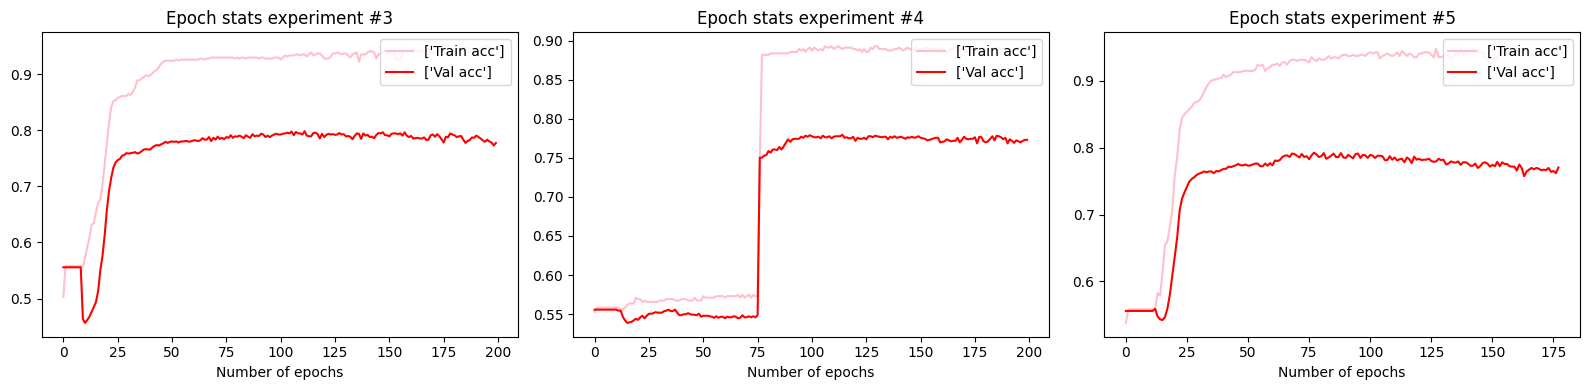

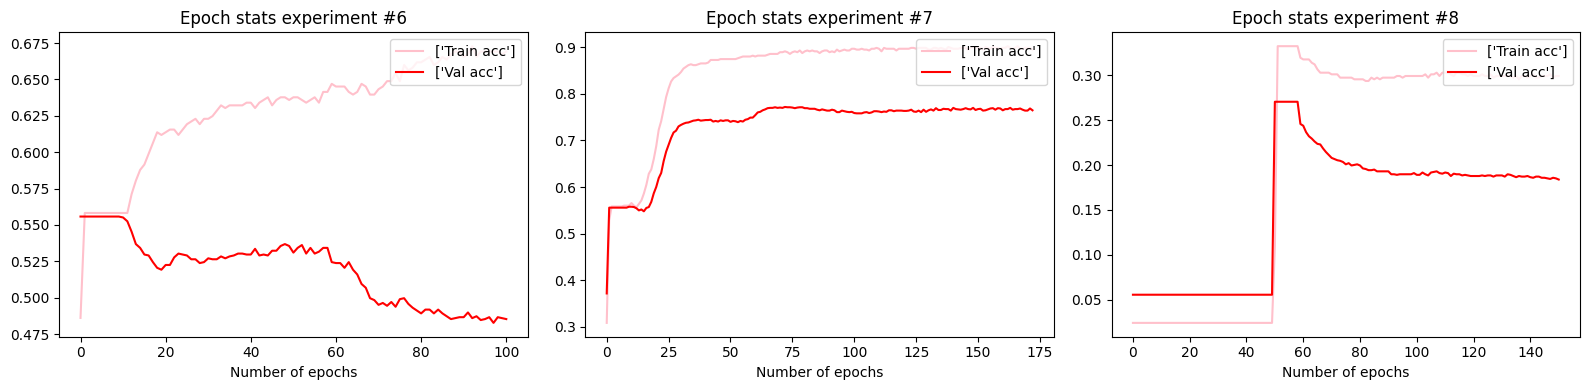

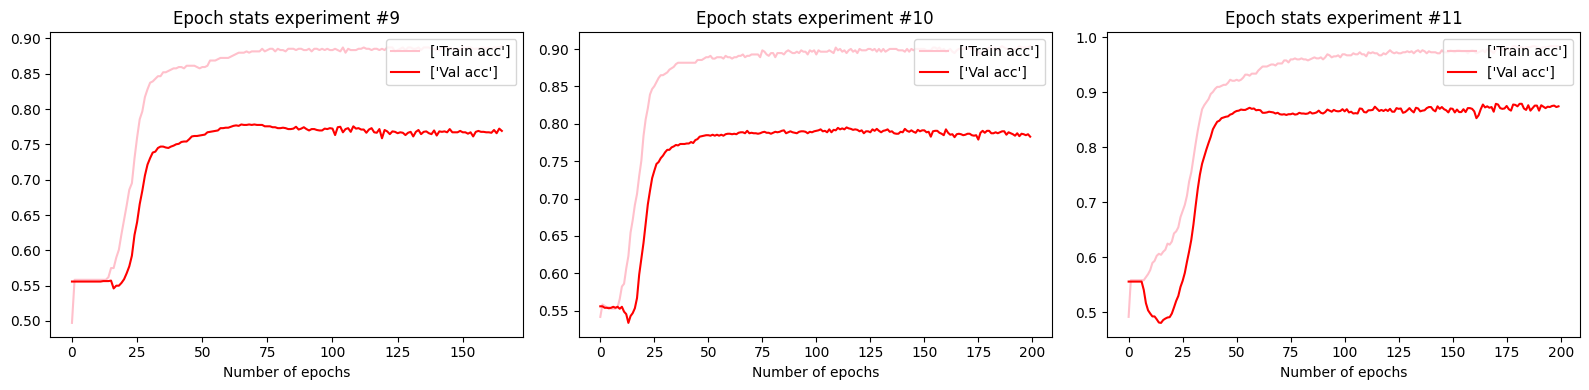

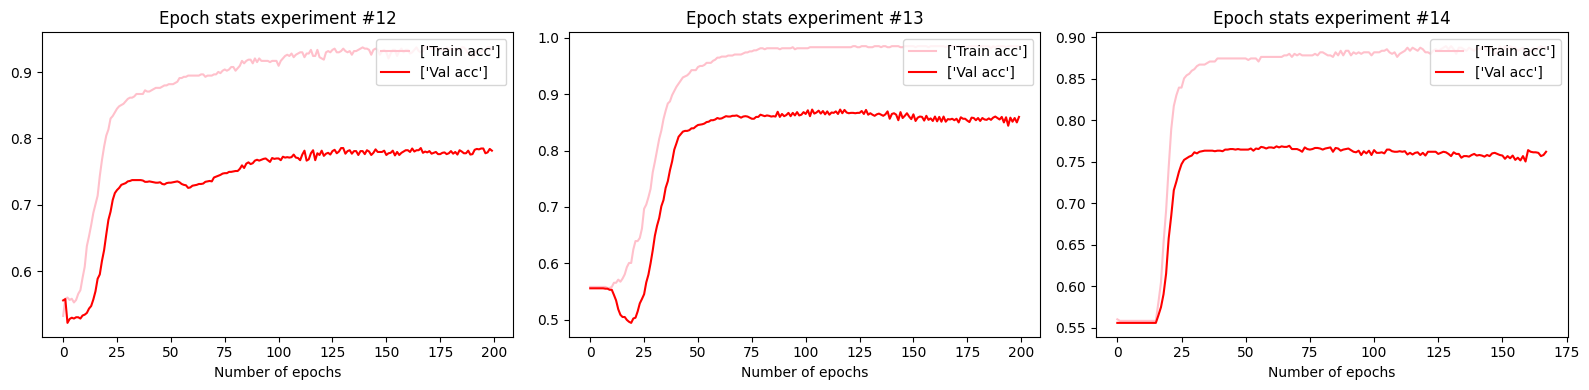

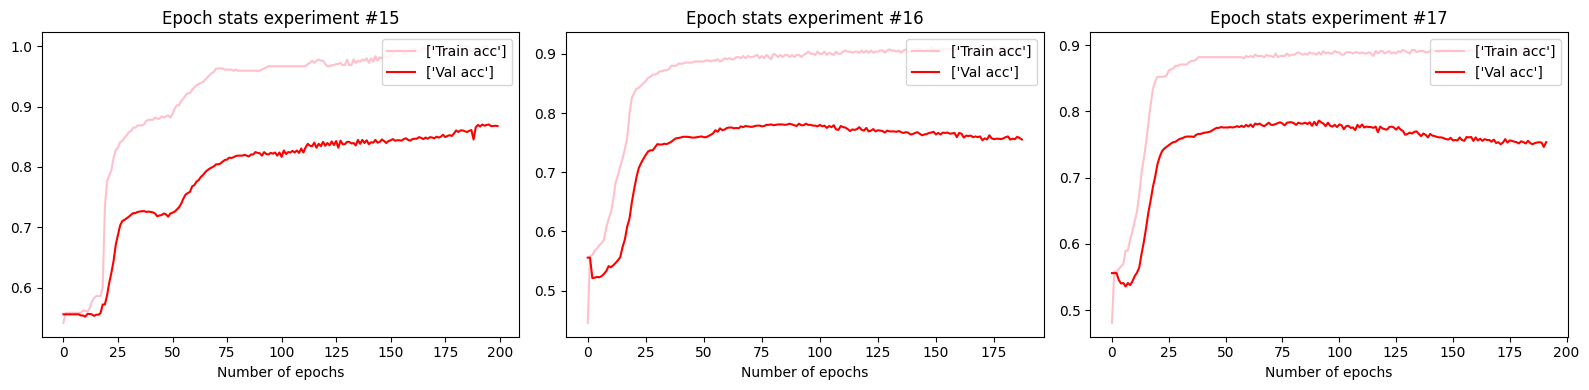

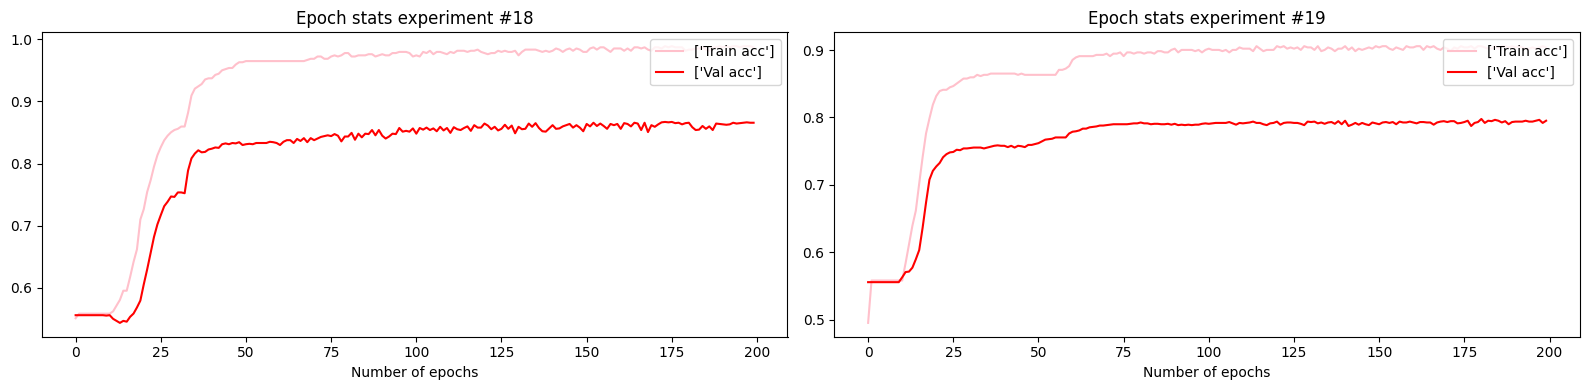

In [36]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

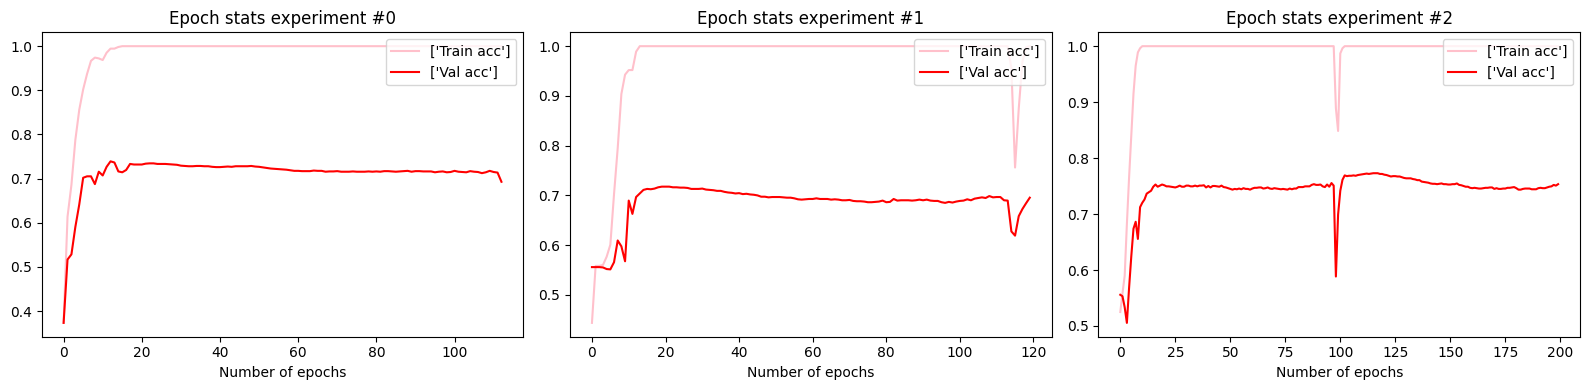

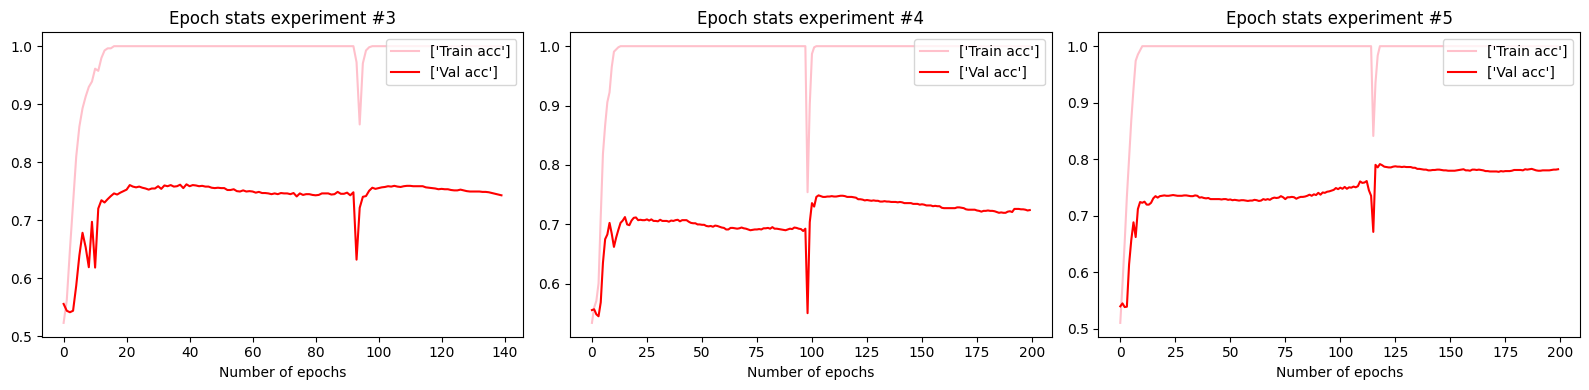

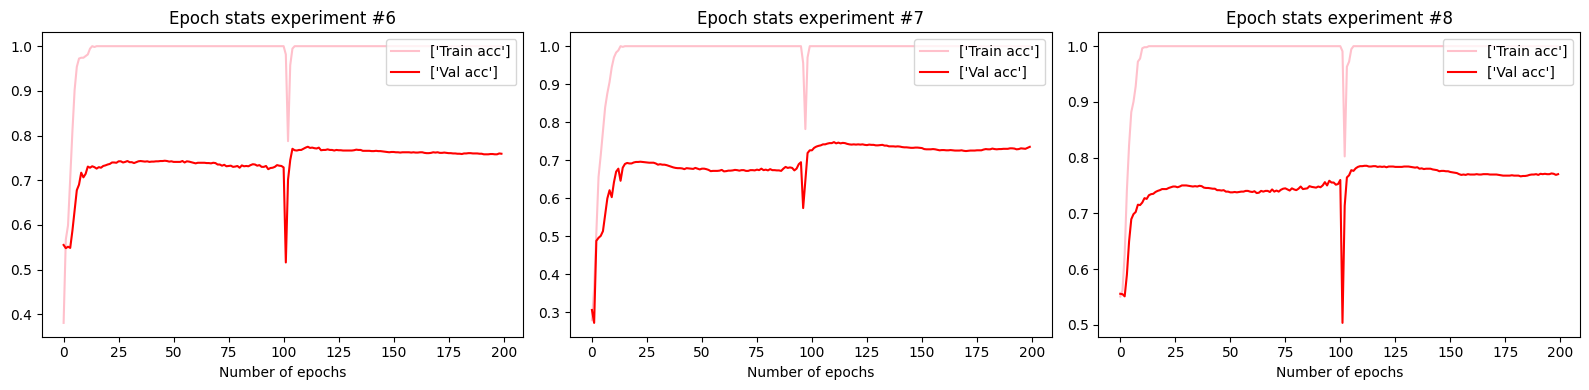

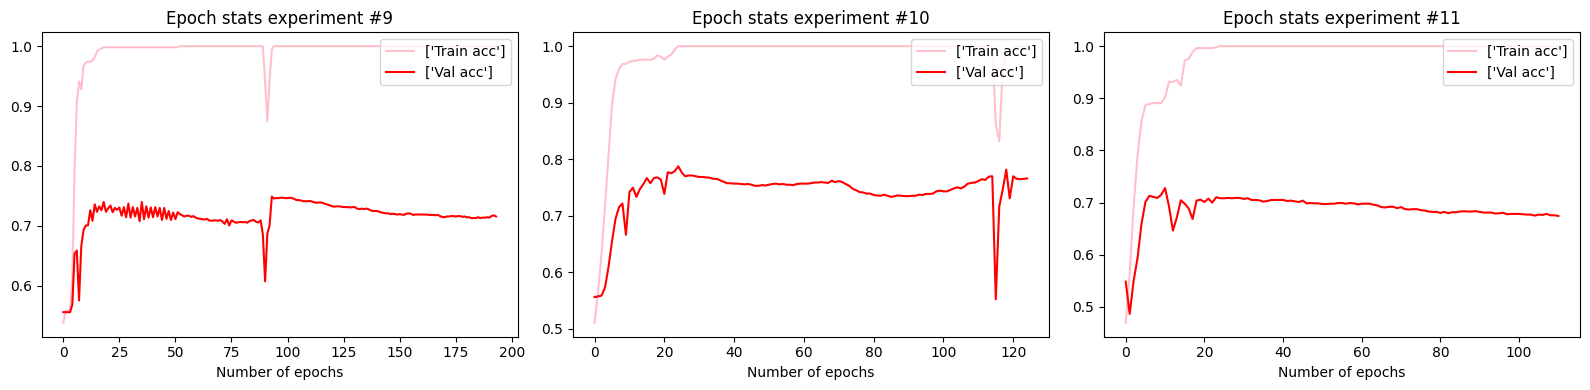

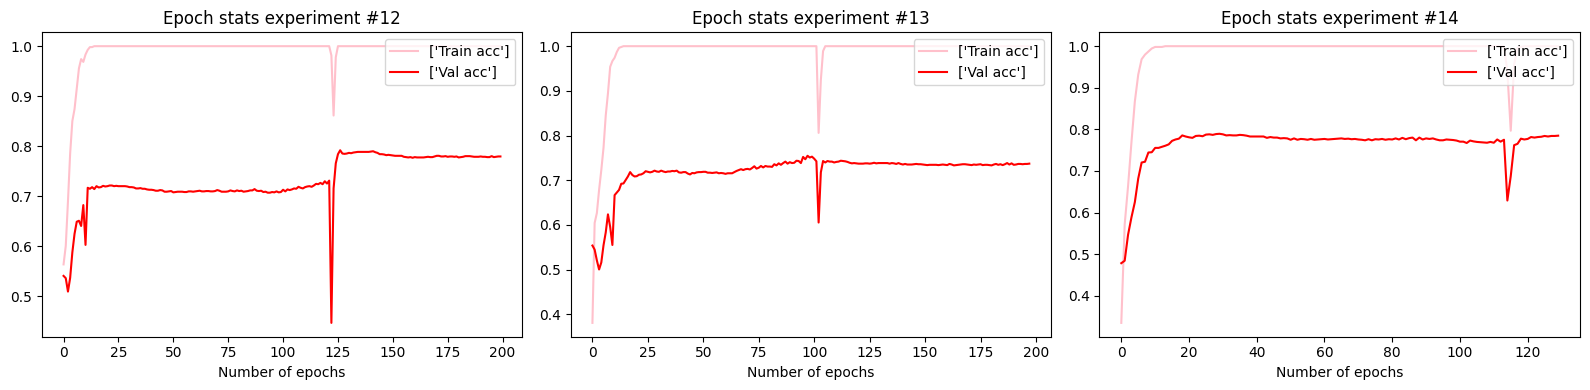

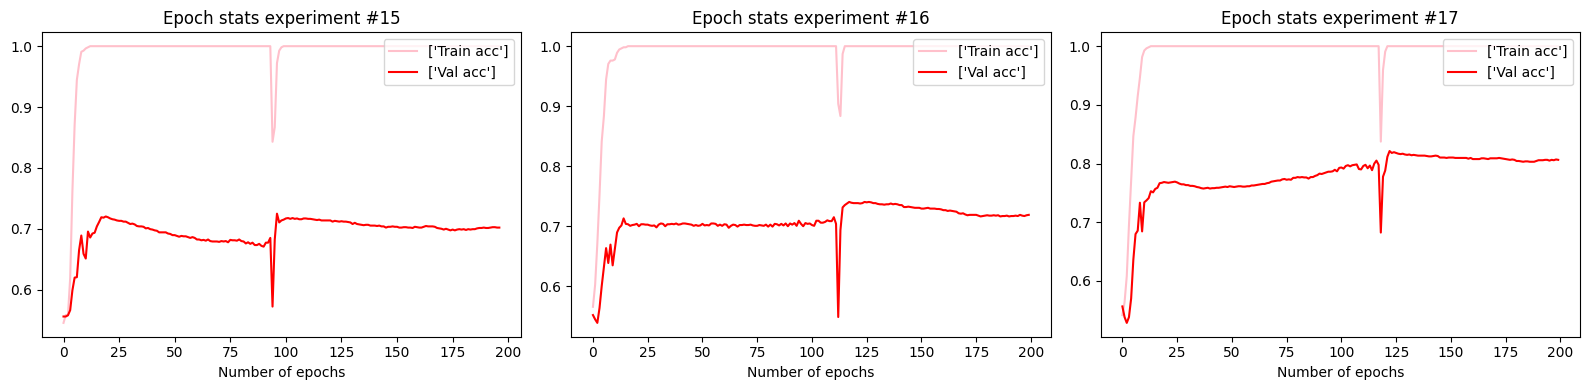

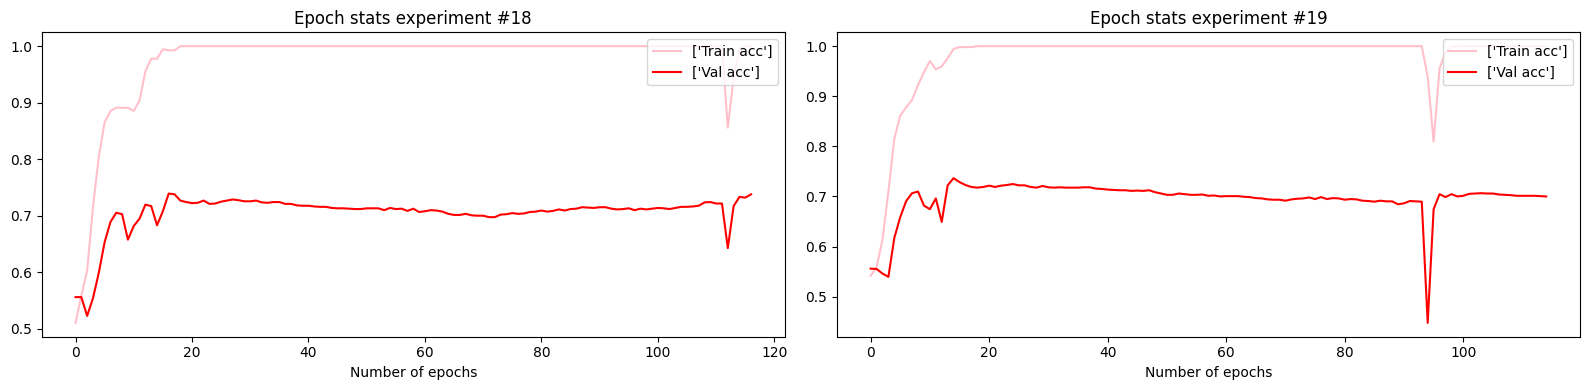

In [37]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [38]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_'))
best_cnn_model = CNN_Model(data, 32, 64, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_'))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('./bestmodels/best_DEEPSET_model_'))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('./bestmodels/best_DEEPSETV2_model_'))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('./bestmodels/best_FEEDFORWARD_model_'))

<All keys matched successfully>

## Top wrong predictions for best performing CNN model

In [40]:
print_wrong_preds_bycases([get_wrong_predictions_bycases(best_cnn_model, x_test_cnn, y_test, test_original)], 10)

4 Atomicity violation cases wrong predicted:
Sample ([',..,..._...._,..', '...__,,_,u__w,..', '._d_.r,.,_,,_._.', 'A'], 'V') | Prediction (['__._...____.__,,', ',,,,,.,_,u_.w___', '__.__.d_,r.,,..,', 'A'], 'V')


IndexError: list index out of range

## Top wrong predictions for best performing LSTM model

In [50]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], 10)

4 false Atomicity violation:


IndexError: list index out of range

## Top wrong predictions for best performing DeepSets V1 model

In [48]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

__.wu.,,_._.,.., ,._,_,_,,__,,dr, | label: False | actual prediction: 0.999997615814209
._,,_._,wu_._,,. _,,...,,_,.,,dr, | label: False | actual prediction: 0.9999970197677612
_,..,wu.__._._,, .,_.,__.dr,,,_,, | label: False | actual prediction: 0.9999969005584717
._,_.._..w_,u,,_ .,__,_d..r,.,_., | label: False | actual prediction: 0.9999967813491821
_.____,...,_w,,u ,,,d,.r.,,.,._,. | label: False | actual prediction: 0.9999967813491821
_,.,_,..w..u._., ._.,._d,,r_,._., | label: False | actual prediction: 0.999996542930603
_.._.,,wu,,,__,, .,._,__.,,,._dr. | label: False | actual prediction: 0.9999957084655762
_..,,,wu_,,._,.. ,._,._.,,_.,_dr. | label: False | actual prediction: 0.9999949932098389
,..__.,_,,w..u., ,..d_,r.,_,._,,. | label: False | actual prediction: 0.9999947547912598
____._,,,.w,_u_, .,.,.,d__r,,.,__ | label: False | actual prediction: 0.999994158744812

Top 10 false negatives: 

.w......,,,_._,, _..._____,__.._r | label: True | actual pre

## Top wrong predictions for best performing DeepSets V2 model

In [49]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

__,_.._,.uw,__,_ ___.,__,__,__dr. | label: True | actual prediction: 0.5
,,,.uw,.,,,.___, ,__dr_,..,,__,,, | label: True | actual prediction: 0.5
.,,,_,,.,.,..,,. _,_.___.._,r._,_ | label: True | actual prediction: 0.5
,__,._._,,,,w,__ .._.,_.,,._dr__. | label: True | actual prediction: 0.5
,_.__.wu_.,,_,_, _..,,r._,_.._.,. | label: True | actual prediction: 0.5
.__.,_,____,_,,. ,.,.___.._...,dr | label: True | actual prediction: 0.5
,,,._,_.,,.,..,. r,,..._,..,..,,_ | label: True | actual prediction: 0.5
_____,_u,.w,_.., _,,.,.,..d__r... | label: True | actual prediction: 0.5
,,_._,___.,,u..w d.,r,.,,,,,...., | label: True | actual prediction: 0.5
.u.,w,.___.__.__ _,d_.r__.,,__,,_ | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [50]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

w,.u,..,,_,_..,, _,_d__r.,,_,_,.. | label: False | actual prediction: 0.9998787641525269
_.____,...,_w,,u ,,,d,.r.,,.,._,. | label: False | actual prediction: 0.9998742341995239
_,_,.w_,u,____,, ,_,,__d.,r_._.._ | label: False | actual prediction: 0.9998500347137451
._..,,,,____..wu .,._.....__dr__. | label: False | actual prediction: 0.9998219609260559
.,,,w,,u_.___.__ ,_d__r.._,.._.,. | label: False | actual prediction: 0.9998086094856262
.w.,u._,,_...._, _,_.,_d..r.__._. | label: False | actual prediction: 0.9998024106025696
__...,,_,,_,,wu_ ,.dr_,..._.,_,_. | label: False | actual prediction: 0.9997851252555847
_,___..._,._w_.u ,,._._d..r_..___ | label: False | actual prediction: 0.9997697472572327
w_,u._,,_,.,,_., .,,,_,d,.r_.__,_ | label: False | actual prediction: 0.9997449517250061
.__,,.___w._u_.. _,d,_r..__,__.,_ | label: False | actual prediction: 0.9997417330741882

Top 10 false negatives: 

._.,,__w_.u..,.. _...,.,r_,,..,.. | label: True | actual 

# Saving Notebook State

In [51]:
import dill
dill.dump_session('notebook_env_interop.db')

# Loading Notebook State

In [48]:
import dill
# dill.load_session('notebook_env_interop.db')